<a href="https://colab.research.google.com/github/Young-Dong/nlp/blob/main/nlp100_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split


with zipfile.ZipFile('NewsAggregatorDataset.zip') as f:
    f.extractall('data')

df = pd.read_csv('data/newsCorpora.csv', sep='\t'
   ,header=None, names=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])
target = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df_target = df[df['PUBLISHER'].isin(target)]

--2022-02-24 11:22:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  33.5MB/s    in 0.8s    

2022-02-24 11:22:45 (33.5 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [2]:
df_target.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
12,13,Europe reaches crunch point on banking union,http://in.reuters.com/article/2014/03/10/eu-ba...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501755
13,14,ECB FOCUS-Stronger euro drowns out ECB's messa...,http://in.reuters.com/article/2014/03/10/ecb-p...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501948
19,20,"Euro Anxieties Wane as Bunds Top Treasuries, S...",http://www.businessweek.com/news/2014-03-10/ge...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503148
20,21,Noyer Says Strong Euro Creates Unwarranted Eco...,http://www.businessweek.com/news/2014-03-10/no...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503366
29,30,REFILE-Bad loan triggers key feature in ECB ba...,http://in.reuters.com/article/2014/03/10/euroz...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470505070


**70. 単語ベクトルの和による特徴量**

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例$x_i$の特徴ベクトル$x_i$を並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．

> $
X=
\left(
\begin{array}{c} 
    x_1\\ x_2\\ ...\\ x_n\\
\end{array}
\right)
∈R^{n×d},
Y=
\left(
\begin{array}{c} 
    y_1\\ y_2\\ ...\\ y_n\\
\end{array}
\right)
∈N^{n}
$

ここで，nは学習データの事例数であり，$x_i$∈$R^d$と$y_i$∈Nはそれぞれ，i∈{1,…,n}番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．N<4で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベル$y_i$は$y_i$∈N<4で表現できる． 以降では，ラベルの種類数をLで表す（今回の分類タスクではL=4である）．

i番目の事例の特徴ベクトル$x_i$は，次式で求める．

> $x_i=\frac{1}{T_i}∑_{t=1}^{T_i}emb(w_i,t)$

ここで，i番目の事例は$T_i$個の（記事見出しの）単語列($w_{i,1},w_{i,2},…,w_{i,Ti}$)から構成され，emb(w)∈$R^d$は単語wに対応する単語ベクトル（次元数はd）である．すなわち，i番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが$x_i$である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，d=300である．

i番目の事例のラベル$y_i$は，次のように定義する．

> $
y_i=\begin{cases}
  {0 (記事x_iが「ビジネス」カテゴリの場合)\\
  1 (記事x_iが「科学技術」カテゴリの場合)\\
  2 (記事x_iが「エンターテイメント」カテゴリの場合)\\
  3 (記事x_iが「健康」カテゴリの場合)}
\end{cases}
$

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

・学習データの特徴量行列: $X_{train}∈R^{Nt×d}$

・学習データのラベルベクトル: $Y_{train}∈N^{Nt}$

・検証データの特徴量行列: $X_{valid}∈R^{Nv×d}$

・検証データのラベルベクトル: $Y_{valid}∈N^{Nv}$

・評価データの特徴量行列: $X_{test}∈R^{Ne×d}$

・評価データのラベルベクトル: $Y_{test}∈N^{Ne}$

なお，$N_t,N_v,N_e$はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [3]:
train, non_train = train_test_split(df_target, test_size=0.2, stratify=df_target['CATEGORY'], random_state=42)
valid, test = train_test_split(non_train, test_size=0.5, stratify=non_train['CATEGORY'], random_state=42)

In [4]:
# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [5]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import word2vec

# official document https://radimrehurek.com/gensim/auto_examples/index.html#documentation

data = '/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(data, binary=True)

In [6]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [7]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10672, 300])
tensor([[ 0.0085,  0.0628,  0.0180,  ..., -0.1601,  0.0352,  0.1221],
        [-0.0952,  0.0496,  0.0650,  ...,  0.0259, -0.0036,  0.1435],
        [ 0.0583,  0.0295, -0.0386,  ...,  0.0912,  0.1007, -0.1357],
        ...,
        [ 0.0287,  0.0165, -0.0757,  ..., -0.0712,  0.0378, -0.0391],
        [-0.0738, -0.0352, -0.0405,  ...,  0.0280,  0.0646,  0.0919],
        [ 0.0394,  0.0317,  0.0094,  ...,  0.0160,  0.0709,  0.0104]])


In [8]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.LongTensor([category_dict[x] for x in train['CATEGORY']])
y_valid = torch.LongTensor([category_dict[x] for x in valid['CATEGORY']])
y_test = torch.LongTensor([category_dict[x] for x in test['CATEGORY']])

print(y_train.size())
print(y_train)

torch.Size([10672])
tensor([2, 0, 1,  ..., 2, 0, 0])


In [9]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

**71. 単層ニューラルネットワークによる予測**

問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$y_1=softmax(x_1W),Y=softmax(X_{[1:4]}W)$

ただし，softmaxはソフトマックス関数，X[1:4]∈R4×dは特徴ベクトルx1,x2,x3,x4を縦に並べた行列である．



> $
X_{[1:4]}=
\left(
\begin{array}{c} 
    x_1\\ x_2\\ x_3\\ x_4\\
\end{array}
\right)
$

行列$W∈R^{d×L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，$y_1∈R^L$は未学習の行列Wで事例$x_1$を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，$Y∈R^{n×L}$は，学習データの事例$x_1,x_2,x_3,x_4$について，各カテゴリに属する確率を行列として表現している．

In [10]:
import torch.nn as nn

# 1) Model
# Linear model f = wx + b
n_samples, n_features = X_train.shape
input_size = n_features
output_size = 4
model = nn.Linear(input_size, output_size)

In [11]:
model(X_train)

tensor([[ 0.0313, -0.0793, -0.0046,  0.0623],
        [-0.0538,  0.0382,  0.0315,  0.0538],
        [ 0.0665,  0.0704, -0.0385, -0.0305],
        ...,
        [ 0.0302,  0.0028,  0.0208,  0.0354],
        [ 0.0355,  0.0493, -0.0313,  0.0261],
        [-0.0173,  0.0845, -0.0021,  0.0719]], grad_fn=<AddmmBackward0>)

In [12]:
y_pred = torch.softmax(model(X_train[:4]), dim=1)
y_pred

tensor([[0.2570, 0.2301, 0.2479, 0.2651],
        [0.2326, 0.2550, 0.2533, 0.2590],
        [0.2624, 0.2634, 0.2362, 0.2381],
        [0.2416, 0.2653, 0.2436, 0.2494]], grad_fn=<SoftmaxBackward0>)

**72. 損失と勾配の計算**

学習データの事例$x_1$と事例集合$x_1,x_2,x_3,x_4$に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例$x_i$に対して損失は次式で計算される．

> $l_i=−log[事例x_iがy_iに分類される確率]$

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [13]:
# 2) Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Forward pass and loss
y_predicted = model(X_train[:1])
loss = criterion(y_predicted, y_train[:1])
# Backward pass
loss.backward()

print(f'損失: {loss:.4f}')
print(f'勾配: {model.weight.grad}')

損失: 1.3947
勾配: tensor([[ 0.0022,  0.0161,  0.0046,  ..., -0.0411,  0.0091,  0.0314],
        [ 0.0020,  0.0144,  0.0041,  ..., -0.0368,  0.0081,  0.0281],
        [-0.0064, -0.0472, -0.0135,  ...,  0.1204, -0.0265, -0.0918],
        [ 0.0023,  0.0166,  0.0048,  ..., -0.0424,  0.0093,  0.0324]])


**73. 確率的勾配降下法による学習**

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [14]:
# 2) Loss and optimizer
learning_rate = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# 3) Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass and loss
    y_predicted = model(X_train)
    loss = criterion(y_predicted, y_train)
    
    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 10, loss = 0.6374
epoch: 20, loss = 0.6308
epoch: 30, loss = 0.4029
epoch: 40, loss = 0.5014
epoch: 50, loss = 0.4404
epoch: 60, loss = 0.4168
epoch: 70, loss = 0.3962
epoch: 80, loss = 0.3802
epoch: 90, loss = 0.3670
epoch: 100, loss = 0.3559


**74. 正解率の計測**

問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [15]:
def acc_c(pred, y):
  pred = torch.max(pred.data,1)[1]
  return (pred == y).sum().item() / len(y)

In [16]:
with torch.no_grad():
  y_predicted = model(X_train)
  y_predicted_cls = y_predicted.round()
  acc = acc_c(y_predicted_cls, y_train)
  print(f'train accuracy: {acc:.4f}')

  y_predicted = model(X_test)
  y_predicted_cls = y_predicted.round()
  acc = acc_c(y_predicted_cls, y_test)
  print(f'test accuracy: {acc:.4f}')

train accuracy: 0.8659
test accuracy: 0.8621


**75. 損失と正解率のプロット**

問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [41]:
# 1) Model
# Linear model f = wx + b
n_samples, n_features = X_train.shape
input_size = n_features
output_size = 4
model = nn.Linear(input_size, output_size)

# 2) Loss and optimizer
learning_rate = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# 3) Training loop
num_epochs = 100
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # Forward pass and loss
  y_train_pred = model(X_train)
  y_valid_pred = model(X_valid)
  loss_train = criterion(y_train_pred, y_train)
  loss_valid = criterion(y_valid_pred, y_valid)

  # Backward pass and update
  loss_train.backward()
  optimizer.step()

  # zero grad before new step
  optimizer.zero_grad()

  with torch.no_grad():
    # 正解率の算出
    acc_train = acc_c(y_train_pred.round(), y_train)
    acc_valid = acc_c(y_valid_pred.round(), y_valid)
    log_train.append([loss_train.detach(), acc_train])
    log_valid.append([loss_valid.detach(), acc_valid])

    # ログを出力
    if (epoch+1) % 10 == 0:
      print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 10, loss_train: 1.2582, accuracy_train: 0.4219, loss_valid: 1.2565, accuracy_valid: 0.4213
epoch: 20, loss_train: 1.1623, accuracy_train: 0.4255, loss_valid: 1.1604, accuracy_valid: 0.4265
epoch: 30, loss_train: 1.1023, accuracy_train: 0.6325, loss_valid: 1.1007, accuracy_valid: 0.6364
epoch: 40, loss_train: 1.0596, accuracy_train: 0.7319, loss_valid: 1.0583, accuracy_valid: 0.7294
epoch: 50, loss_train: 1.0261, accuracy_train: 0.7281, loss_valid: 1.0253, accuracy_valid: 0.7234
epoch: 60, loss_train: 0.9983, accuracy_train: 0.7200, loss_valid: 0.9979, accuracy_valid: 0.7046
epoch: 70, loss_train: 0.9742, accuracy_train: 0.7182, loss_valid: 0.9743, accuracy_valid: 0.7039
epoch: 80, loss_train: 0.9529, accuracy_train: 0.7213, loss_valid: 0.9534, accuracy_valid: 0.7121
epoch: 90, loss_train: 0.9337, accuracy_train: 0.7269, loss_valid: 0.9346, accuracy_valid: 0.7241
epoch: 100, loss_train: 0.9161, accuracy_train: 0.7338, loss_valid: 0.9175, accuracy_valid: 0.7354


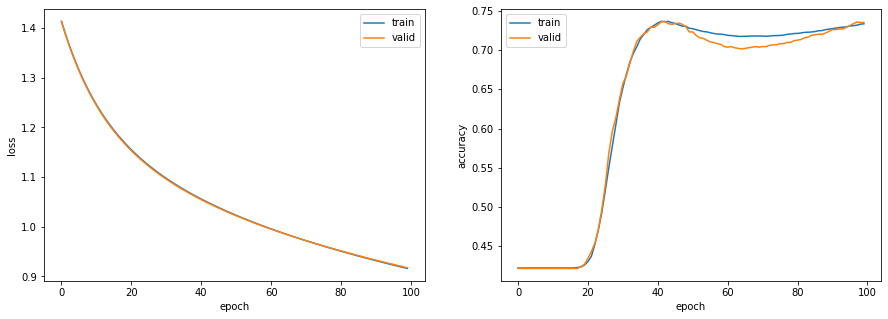

In [42]:
import numpy as np
from matplotlib import pyplot as plt

# 可視化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

**76. チェックポイント**

問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [43]:
# 1) Model
# Linear model f = wx + b
n_samples, n_features = X_train.shape
input_size = n_features
output_size = 4
model = nn.Linear(input_size, output_size)

# 2) Loss and optimizer
learning_rate = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# 3) Training loop
num_epochs = 100
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # Forward pass and loss
  y_train_pred = model(X_train)
  y_valid_pred = model(X_valid)
  loss_train = criterion(y_train_pred, y_train)
  loss_valid = criterion(y_valid_pred, y_valid)

  # Backward pass and update
  loss_train.backward()
  optimizer.step()

  # zero grad before new step
  optimizer.zero_grad()

  with torch.no_grad():
    # 正解率の算出
    acc_train = acc_c(y_train_pred.round(), y_train)
    acc_valid = acc_c(y_valid_pred.round(), y_valid)
    log_train.append([loss_train.detach(), acc_train])
    log_valid.append([loss_valid.detach(), acc_valid])

    # ログを出力
    if (epoch+1) % 10 == 0:
      print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')
  
  # チェックポイントの保存
  torch.save(model, f'checkpoint{epoch + 1}.pth')

epoch: 10, loss_train: 1.2445, accuracy_train: 0.4219, loss_valid: 1.2428, accuracy_valid: 0.4213
epoch: 20, loss_train: 1.1524, accuracy_train: 0.4322, loss_valid: 1.1506, accuracy_valid: 0.4318
epoch: 30, loss_train: 1.0945, accuracy_train: 0.6868, loss_valid: 1.0929, accuracy_valid: 0.6829
epoch: 40, loss_train: 1.0531, accuracy_train: 0.7464, loss_valid: 1.0518, accuracy_valid: 0.7399
epoch: 50, loss_train: 1.0206, accuracy_train: 0.7352, loss_valid: 1.0198, accuracy_valid: 0.7241
epoch: 60, loss_train: 0.9936, accuracy_train: 0.7254, loss_valid: 0.9932, accuracy_valid: 0.7151
epoch: 70, loss_train: 0.9702, accuracy_train: 0.7248, loss_valid: 0.9702, accuracy_valid: 0.7144
epoch: 80, loss_train: 0.9495, accuracy_train: 0.7279, loss_valid: 0.9499, accuracy_valid: 0.7196
epoch: 90, loss_train: 0.9307, accuracy_train: 0.7336, loss_valid: 0.9315, accuracy_valid: 0.7234
epoch: 100, loss_train: 0.9136, accuracy_train: 0.7407, loss_valid: 0.9149, accuracy_valid: 0.7301


**77. ミニバッチ化**

問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [84]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    if isinstance(idx, torch.Tensor):
      idx = idx.tolist()
    return [self.X[idx], self.y[idx]]

In [85]:
from torch.utils.data import DataLoader

dataset_train = CreateDataset(X_train, y_train)
dataset_valid = CreateDataset(X_valid, y_valid)
dataset_test = CreateDataset(X_test, y_test)

print(len(dataset_train))

10672


In [86]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

In [89]:
from torch.utils.data import Dataset, DataLoader

# gradient computation etc. not efficient for whole data set
# -> divide dataset into small batches

'''
# training loop
for epoch in range(num_epochs):
    # loop over all batches
    for i in range(total_batches):
        batch_x, batch_y = ...
'''

# epoch = one forward and backward pass of ALL training samples
# batch_size = number of training samples used in one forward/backward pass
# number of iterations = number of passes, each pass (forward+backward) using [batch_size] number of sampes
# e.g : 100 samples, batch_size=20 -> 100/20=5 iterations for 1 epoch
# --> DataLoader can do the batch computation for us

# 1) Model
# Linear model f = wx + b
n_samples, n_features = X_train.shape
input_size = n_features
output_size = 4
model = nn.Linear(input_size, output_size)

# 2) Loss and optimizer
learning_rate = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    for inputs, labels in dataloader_train:
      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # 勾配をゼロで初期化
      optimizer.zero_grad()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    if (epoch+1) % 1 == 0:
      print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [90]:
# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'batch_size: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 10)

batch_size: 1
epoch: 1, loss_train: 0.2983, accuracy_train: 0.8955, loss_valid: 0.3355, accuracy_valid: 0.8853, 8.6408sec
epoch: 2, loss_train: 0.2671, accuracy_train: 0.9102, loss_valid: 0.3132, accuracy_valid: 0.8996, 6.6539sec
epoch: 3, loss_train: 0.2529, accuracy_train: 0.9153, loss_valid: 0.3022, accuracy_valid: 0.8966, 6.5370sec
epoch: 4, loss_train: 0.2519, accuracy_train: 0.9145, loss_valid: 0.3111, accuracy_valid: 0.8913, 6.4146sec
epoch: 5, loss_train: 0.2396, accuracy_train: 0.9180, loss_valid: 0.2989, accuracy_valid: 0.8943, 6.6008sec
epoch: 6, loss_train: 0.2398, accuracy_train: 0.9198, loss_valid: 0.3027, accuracy_valid: 0.9033, 6.5312sec
epoch: 7, loss_train: 0.2305, accuracy_train: 0.9229, loss_valid: 0.2982, accuracy_valid: 0.9003, 6.4740sec
epoch: 8, loss_train: 0.2318, accuracy_train: 0.9214, loss_valid: 0.3035, accuracy_valid: 0.8988, 6.5231sec
epoch: 9, loss_train: 0.2258, accuracy_train: 0.9239, loss_valid: 0.2985, accuracy_valid: 0.9010, 6.5343sec
epoch: 10, los

**78. GPU上での学習**

問題77のコードを改変し，GPU上で学習を実行せよ．

In [91]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Model
# Linear model f = wx + b
n_samples, n_features = X_train.shape
input_size = n_features
output_size = 4
model = nn.Linear(input_size, output_size).to(device)

# 2) Loss and optimizer
learning_rate = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    for inputs, labels in dataloader_train:
      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # 勾配をゼロで初期化
      optimizer.zero_grad()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    if (epoch+1) % 1 == 0:
      print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [92]:
# モデルの学習
print(device)
for batch_size in [2 ** i for i in range(11)]:
  print(f'batch_size: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 2)

cuda
batch_size: 1
epoch: 1, loss_train: 0.2990, accuracy_train: 0.8975, loss_valid: 0.3373, accuracy_valid: 0.8898, 16.1906sec
epoch: 2, loss_train: 0.2726, accuracy_train: 0.9041, loss_valid: 0.3211, accuracy_valid: 0.8853, 15.6820sec
batch_size: 2
epoch: 1, loss_train: 0.2587, accuracy_train: 0.9123, loss_valid: 0.3091, accuracy_valid: 0.8958, 7.8985sec
epoch: 2, loss_train: 0.2523, accuracy_train: 0.9146, loss_valid: 0.3055, accuracy_valid: 0.8951, 7.9018sec
batch_size: 4
epoch: 1, loss_train: 0.2504, accuracy_train: 0.9167, loss_valid: 0.3025, accuracy_valid: 0.9048, 3.9857sec
epoch: 2, loss_train: 0.2472, accuracy_train: 0.9175, loss_valid: 0.3016, accuracy_valid: 0.9003, 4.0658sec
batch_size: 8
epoch: 1, loss_train: 0.2466, accuracy_train: 0.9172, loss_valid: 0.3007, accuracy_valid: 0.9040, 2.0816sec
epoch: 2, loss_train: 0.2449, accuracy_train: 0.9179, loss_valid: 0.3001, accuracy_valid: 0.9018, 2.1188sec
batch_size: 16
epoch: 1, loss_train: 0.2446, accuracy_train: 0.9185, loss

**79. 多層ニューラルネットワーク**

問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [94]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Model
# Linear model f = wx + b
n_samples, n_features = X_train.shape
input_size = n_features
output_size = 4

# Multiclass problem
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # no softmax at the end
        return out

model = NeuralNet2(input_size=input_size, hidden_size=5, num_classes=output_size).to(device)


# 2) Loss and optimizer
learning_rate = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    for inputs, labels in dataloader_train:
      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # 勾配をゼロで初期化
      optimizer.zero_grad()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    if (epoch+1) % 10 == 0:
      print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [95]:
# デバイスの指定
device = torch.device('cuda')
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 100)

epoch: 10, loss_train: 0.3310, accuracy_train: 0.8893, loss_valid: 0.3660, accuracy_valid: 0.8793, 0.4547sec
epoch: 20, loss_train: 0.2471, accuracy_train: 0.9168, loss_valid: 0.3054, accuracy_valid: 0.8981, 0.4653sec
epoch: 30, loss_train: 0.2278, accuracy_train: 0.9239, loss_valid: 0.2962, accuracy_valid: 0.9055, 0.4688sec
epoch: 40, loss_train: 0.2169, accuracy_train: 0.9264, loss_valid: 0.2924, accuracy_valid: 0.9018, 0.4565sec
epoch: 50, loss_train: 0.2112, accuracy_train: 0.9267, loss_valid: 0.2917, accuracy_valid: 0.9025, 0.4852sec
epoch: 60, loss_train: 0.2088, accuracy_train: 0.9288, loss_valid: 0.2943, accuracy_valid: 0.9040, 0.4782sec
epoch: 70, loss_train: 0.2046, accuracy_train: 0.9302, loss_valid: 0.2969, accuracy_valid: 0.8996, 0.4515sec
epoch: 80, loss_train: 0.2029, accuracy_train: 0.9300, loss_valid: 0.2986, accuracy_valid: 0.9025, 0.4767sec
epoch: 90, loss_train: 0.2004, accuracy_train: 0.9310, loss_valid: 0.2995, accuracy_valid: 0.8988, 0.4619sec
epoch: 100, loss_tr

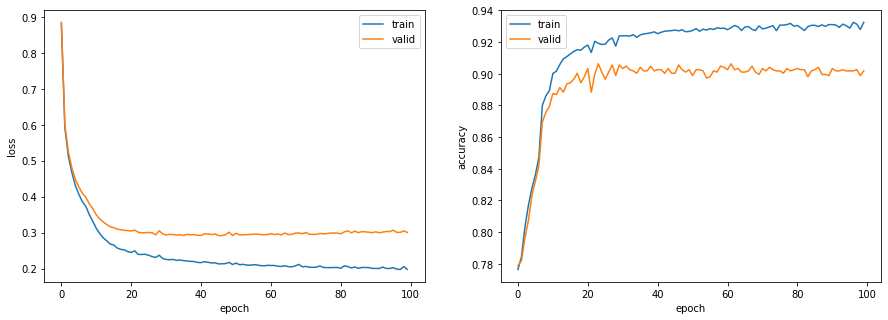

In [96]:
# 可視化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()